In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


# ***1. Load the Data***

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df1 = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df1

id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
0       165034    15773898   Lucchese          586    France  Female  23.0   
1       165035    15782418       Nott          683    France  Female  46.0   
2       165036    15807120         K?          656    France  Female  34.0   
3       165037    15808905  O'Donnell          681    France    Male  36.0   
4       165038    15607314    Higgins          752   Germany    Male  38.0   
...        ...         ...        ...          ...       ...     ...   ...   
110018  275052    15662091      P'eng          570     Spain    Male  29.0   
110019  275053    15774133        Cox          575    France  Female  36.0   
110020  275054    15728456      Ch'iu          712    France    Male  31.0   
110021  275055    15687541   Yegorova          709    France  Female  32.0   
110022  275056    15663942       Tuan          621    France  Female  37.0   

        Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0            2       0.00              2        0.0             1.0   
1            2       0.00              1        1.0             0.0   
2            7       0.00              2        1.0             0.0   
3            8       0.00              1        1.0             0.0   
4           10  121263.62              1        1.0             0.0   
...        ...        ...            ...        ...             ...   
110018       7  116099.82              1        1.0             1.0   
110019       4  178032.53              1        1.0             1.0   
110020       2       0.00              2        1.0             0.0   
110021       3       0.00              1        1.0             1.0   
110022       7   87848.39              1        1.0             0.0   

        EstimatedSalary  
0             160976.75  
1              72549.27  
2             138882.09  
3             113931.57  
4             139431.00  
...                 ...  
110018        148087.62  
110019         42181.68  
110020         16287.38  
110021        158816.58  
110022         24210.56  

[110023 rows x 13 columns]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score

# **2. Analyse the Data**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


<Axes: ylabel='Frequency'>

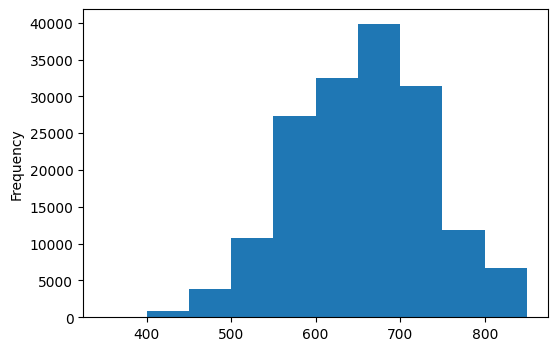

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
df.CreditScore.plot(kind='hist', ax=ax)

# **3. Data Cleaning**

In [6]:
X = df.drop(['id','CustomerId','Surname','Exited'], axis=1)
id = df1.id
df1 = df1.drop(['id','CustomerId','Surname'], axis=1)
y = df[['Exited']]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_col = ['Gender','Geography', 'HasCrCard', 'IsActiveMember']
num_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
min_max = MinMaxScaler()
one_hot = OneHotEncoder()
preprocessing = ColumnTransformer([('num', min_max, num_col), ('cat', one_hot, cat_col)])

In [9]:
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.fit_transform(X_test)

# **4. Fit the Model**

In [10]:
for model in [RandomForestClassifier, XGBClassifier, GradientBoostingClassifier]:
    cls = model()
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    s = cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=kfold, verbose=0)
    print(
        f"{model.__name__:22}  AUC: "
        f"{s.mean():.3f} STD: {s.std():.2f}"
    )

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

RandomForestClassifier  AUC: 0.872 STD: 0.00
XGBClassifier           AUC: 0.886 STD: 0.00


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

GradientBoostingClassifier  AUC: 0.888 STD: 0.00


In [11]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_predict = gb.predict(X_test)
prob = gb.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_predict)
accuracy

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8663010876480747

In [12]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, prob[:, 1])

0.8899169200171797

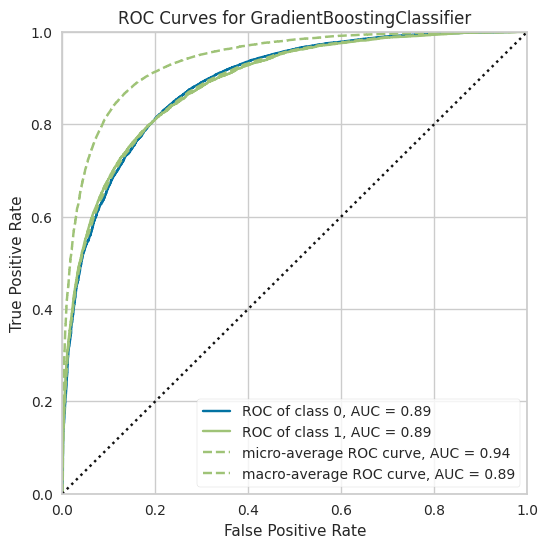

<Axes: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [13]:
from yellowbrick.classifier import ROCAUC
fig, ax =plt.subplots(figsize=(6,6))
roc_viz = ROCAUC(gb)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test)
roc_viz.poof()

In [14]:
y_final = preprocessing.transform(df1)
y_pred_final= gb.predict_proba(y_final)[:,1]
prediction = pd.DataFrame({"id": id,"Exited": y_pred_final})
prediction

id    Exited
0       165034  0.023634
1       165035  0.828897
2       165036  0.038116
3       165037  0.245149
4       165038  0.344603
...        ...       ...
110018  275052  0.043858
110019  275053  0.085781
110020  275054  0.026653
110021  275055  0.144418
110022  275056  0.194421

[110023 rows x 2 columns]

In [15]:
prediction.to_csv('submission.csv', index=False)